In [2]:
import keras
import cv2
import re
import numpy as np
import argparse
import os
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16,InceptionV3,InceptionResNetV2, DenseNet201, EfficientNetB3, ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from skimage.io import imread
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
import seaborn as sn
import itertools
from sklearn.metrics import precision_recall_fscore_support
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Add, Activation, Multiply, concatenate
from keras.callbacks import ReduceLROnPlateau
import tensorflow_addons as tfa
%matplotlib inline




##Change Paths here

In [82]:
#print(os.listdir('/content/drive/MyDrive/Colab Notebooks/HW3/'))
#pre_test = '/content/drive/MyDrive/Colab Notebooks/HW3/final_dataset/test/'
#pre_train = '/content/drive/MyDrive/Colab Notebooks/HW3/final_dataset/train/'
#pre_valid = '/content/drive/MyDrive/Colab Notebooks/HW3/final_dataset/val/'
path ='/content/drive/MyDrive/Colab Notebooks/HW3/IML_CXR/' ##training dataset
path2 = '/content/drive/MyDrive/Colab Notebooks/HW3/cxr_label_train.csv'##lable csv file
path3 = '/content/drive/MyDrive/Colab Notebooks/HW3/IML_CXR_TEST/'##final prediction input
modelpath = '/content/drive/MyDrive/Colab Notebooks/HW3/DenseNet_Results/best_finetuned(45)_densenet.h5'
filenames = os.listdir(path)


In [83]:
test_filenames = os.listdir(path3)

test_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
final_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = final_df.shape[0]


In [84]:

labels = pd.read_csv(path2)
id = labels.groupby('hospital_outcome')
print(id.size())
df = labels.copy()
label0 = id.get_group(0)
label_0 = label0['PATIENT ID']
label_0.to_numpy()
label1 = id.get_group(1)
label_1 = label1['PATIENT ID']
label_1.to_numpy()
df['PATIENT ID'] = df['PATIENT ID'].astype(str) + '.jpg'
df['hospital_outcome'] = df['hospital_outcome'].astype(str)

hospital_outcome
0    1229
1     164
dtype: int64


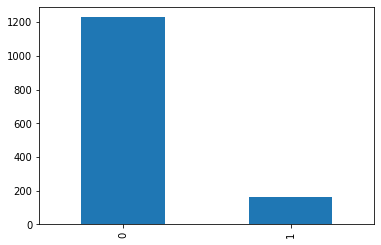

In [85]:
df['hospital_outcome'].value_counts().plot.bar()

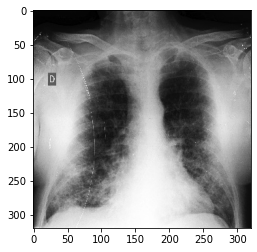

In [86]:
import random
sample = random.choice(filenames)
image = load_img(path+sample)
plt.imshow(image)

[]


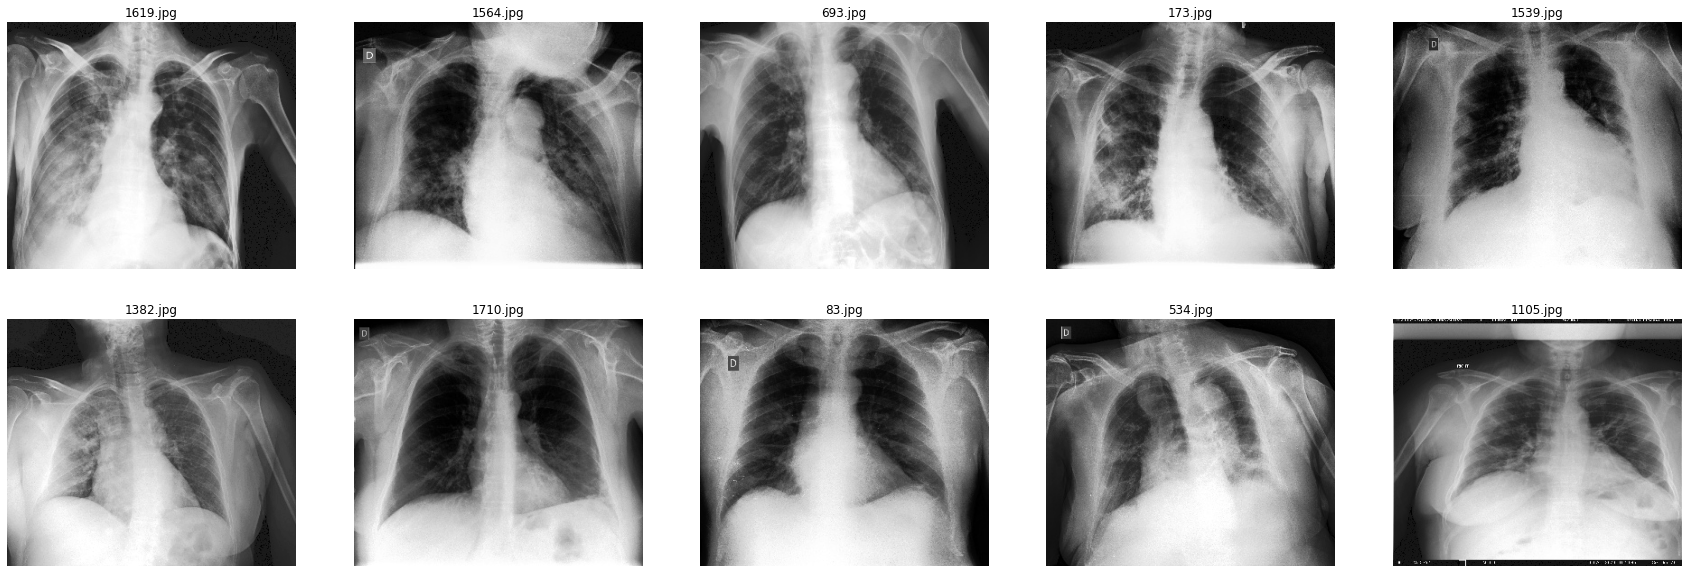

In [87]:
# Get few samples for both the classes
covid_samples = (df[df['hospital_outcome']=='1']['PATIENT ID'].iloc[:5]).tolist()
covid_id = (df[df['PATIENT ID']=='1']['PATIENT ID'].iloc[:5]).tolist()
normal_samples = (df[df['hospital_outcome']=='0']['PATIENT ID'].iloc[:5]).tolist()
normal_id = (df[df['PATIENT ID']=='0']['PATIENT ID'].iloc[:5]).tolist()
# Concat the data in a single list and del the above two list
samples = covid_samples + normal_samples
ids = covid_id + normal_id
del covid_samples, normal_samples
print(ids)

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(path+samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        #ax[i//5, i%5].set_title("Covid",samples[i])
        ax[i//5, i%5].set_title(samples[i])
    else:
        ax[i//5, i%5].set_title(samples[i])
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [88]:
train_valid_df, test_df = train_test_split(df,test_size =0.1,stratify = df['hospital_outcome'])
train_valid_df = train_valid_df.reset_index()
test_df = test_df.reset_index()
#print(test_df.groupby('hospital_outcome').size())
train_valid_df_size = train_valid_df.shape[0]
test_size = test_df.shape[0]

In [89]:
train_df, valid_df = train_test_split(train_valid_df,test_size =0.1,stratify = train_valid_df['hospital_outcome'])
print(train_df.groupby('hospital_outcome').size())
print(test_df.groupby('hospital_outcome').size())
print(valid_df.groupby('hospital_outcome').size())
train_size = train_df.shape[0]
valid_size = valid_df.shape[0]
valid_df.head()

hospital_outcome
0    994
1    133
dtype: int64
hospital_outcome
0    124
1     16
dtype: int64
hospital_outcome
0    111
1     15
dtype: int64


,index,PATIENT ID,hospital_outcome
1145,140,1810.jpg,0
175,1289,1328.jpg,0
434,173,400.jpg,0
612,829,1253.jpg,0
642,673,2219.jpg,0


In [90]:
del train_df['index']
del test_df['index']
del valid_df['index']


##Pretraining Other Xray Images 

In [30]:
'''
pretrain_datagen = ImageDataGenerator(rescale=1./255,
 validation_split = 0,
)
pretest_datagen = ImageDataGenerator(rescale = 1./255)
'''

'\npretrain_datagen = ImageDataGenerator(rescale=1./255,\n validation_split = 0,\n)\npretest_datagen = ImageDataGenerator(rescale = 1./255)\n'

In [31]:
'''
pretrain_generator = pretrain_datagen.flow_from_directory(pre_train,
    target_size = (320, 320),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
pretest_generator = pretest_datagen.flow_from_directory(pre_test,
    target_size = (320, 320),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)
preval_generator = pretest_datagen.flow_from_directory(pre_valid,
    target_size = (320, 320),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)
'''

'\npretrain_generator = pretrain_datagen.flow_from_directory(pre_train,\n    target_size = (320, 320),\n    shuffle=True,seed=42,class_mode="categorical",\n    color_mode = \'rgb\',\n    batch_size = 16)\npretest_generator = pretest_datagen.flow_from_directory(pre_test,\n    target_size = (320, 320),\n    color_mode = \'rgb\',\n    batch_size = 1,seed=42,class_mode="categorical",\n    shuffle = False)\npreval_generator = pretest_datagen.flow_from_directory(pre_valid,\n    target_size = (320, 320),\n    color_mode = \'rgb\',\n    batch_size = 1,seed=42,class_mode="categorical",\n    shuffle = False)\n'

In [32]:
'''
basemodel = DenseNet201(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
headModel = basemodel.output
headModel = GlobalAveragePooling2D()(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
'''

'\nbasemodel = DenseNet201(weights=\'imagenet\', include_top=False,input_tensor=Input(shape=(320, 320, 3)))\nheadModel = basemodel.output\nheadModel = GlobalAveragePooling2D()(headModel)#pool_size=(4, 4)\nheadModel = Flatten(name="flatten")(headModel)\nheadModel = Dense(128, activation="relu")(headModel)\nheadModel = Dropout(0.5)(headModel)\nheadModel = Dense(2, activation="softmax")(headModel)\n'

In [33]:
#model = Model(inputs=basemodel.input, outputs=headModel)

In [ ]:
'''
epochs= 15
lr = 1e-4
BS = 16
'''

'\nepochs= 15\nlr = 1e-4\nBS = 16\n'

In [ ]:
'''
filepath="base_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
'''

'\nfilepath="base_model_weights.h5"\ncheckpoint = ModelCheckpoint(filepath, monitor=\'val_accuracy\', verbose=1, save_best_only=True, mode=\'max\')\ncallbacks_list = [checkpoint]\n'

In [ ]:
#model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4,decay=lr/epochs),metrics=["accuracy"])

In [ ]:
'''
model.fit_generator(pretrain_generator,
                    steps_per_epoch = 320//BS,
                    epochs = epochs,
                    validation_data = preval_generator,
                    validation_steps = 26,
                   callbacks=callbacks_list,
                   class_weight=cw2,
                   )
'''

'\nmodel.fit_generator(pretrain_generator,\n                    steps_per_epoch = 320//BS,\n                    epochs = epochs,\n                    validation_data = preval_generator,\n                    validation_steps = 26,\n                   callbacks=callbacks_list,\n                   class_weight=cw2,\n                   )\n'

##Data Preprocessing

In [91]:
train_datagen = ImageDataGenerator(rescale=1./255,
 featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False
)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [92]:
train_generator = train_datagen.flow_from_dataframe(train_df,
    path,                                               
    target_size = (320, 320),
    shuffle=True,seed=42,
    x_col='PATIENT ID',
    y_col='hospital_outcome',
    class_mode='categorical',
    #color_mode = 'grayscale',
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_dataframe(test_df,
    path,                                                
    target_size = (320, 320),
    batch_size = 1,seed=42,
    x_col='PATIENT ID',
    y_col= 'hospital_outcome' ,
    #color_mode = 'grayscale',
    color_mode = 'rgb',
    class_mode='categorical',
    shuffle = False
    )
val_generator = test_datagen.flow_from_dataframe(valid_df,
    path,                                             
    target_size = (320, 320),
    batch_size = 1,seed=42,
    x_col='PATIENT ID',
    y_col='hospital_outcome',
    #color_mode = 'grayscale',
    color_mode = 'rgb',
    class_mode='categorical',
    shuffle = False
    )
final_generator = test_datagen.flow_from_dataframe(
    final_df,
    path3,
    target_size = (320, 320),
    x_col='filename',
    y_col=None,
    class_mode=None,
    color_mode = 'rgb',
    shuffle = False
)

Found 1127 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 126 validated image filenames belonging to 2 classes.
Found 457 validated image filenames.


##Building Model and Train Classifer

In [15]:

#basemodel = InceptionV3(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
basemodel = DenseNet201(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
#basemodel = InceptionResNetV2(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
#basemodel = VGG16(input_tensor=Input(shape=(320, 320, 3)),include_top=False, weights="imagenet")
#basemodel = ResNet50(input_tensor=Input(shape=(320, 320, 3)),include_top=False, weights="imagenet")
#basemodel =EfficientNetB4(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
#basemodel = efn.EfficientNetB3(weights = 'imagenet',include_top = False, input_shape = (320, 320, 3))

74842112/74836368 [==============================] - 1s 0us/step


In [16]:
headModel = basemodel.output
headModel = GlobalAveragePooling2D()(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
#headModel = Dense(32, activation="relu")(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [17]:
model = Model(inputs=basemodel.input, outputs=headModel)
#model.summary()

In [18]:
basemodel.trainable=False

In [19]:
epochs= 20
batch_size = 16
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5,decay=1e-4/epochs),metrics=["accuracy",tf.keras.metrics.AUC(),tfa.metrics.F1Score(num_classes=2)])

In [20]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
cw = dict(zip( np.unique(train_generator.classes), class_weights))
print(cw)

{0: 0.5669014084507042, 1: 4.2368421052631575}


In [ ]:
filepath="best_finetuned.h5"
lr_p = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=0,factor=0.3, min_lr=0.000001)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,lr_p]

In [ ]:
'''
model.fit_generator(train_generator,
                    steps_per_epoch = train_df.shape[0]//batch_size,
                    epochs = epochs,
                    validation_data = val_generator,
                    callbacks=callbacks_list,
                    class_weight=cw
                   )
'''

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
70/70 [==============================] - 41s 461ms/step - loss: 0.7453 - accuracy: 0.6364 - auc_6: 0.6790 - f1_score: 0.4953 - val_loss: 0.6360 - val_accuracy: 0.7540 - val_auc_6: 0.8531 - val_f1_score: 0.5654

Epoch 00001: val_loss improved from inf to 0.63603, saving model to best_finetuned.h5
Epoch 2/20
70/70 [==============================] - 29s 415ms/step - loss: 0.7177 - accuracy: 0.6096 - auc_6: 0.6514 - f1_score: 0.4666 - val_loss: 0.6559 - val_accuracy: 0.6587 - val_auc_6: 0.7735 - val_f1_score: 0.5242

Epoch 00002: val_loss did not improve from 0.63603
Epoch 3/20
70/70 [==============================] - 29s 416ms/step - loss: 0.7342 - accuracy: 0.5466 - auc_6: 0.5893 - f1_score: 0.4450 - val_loss: 0.6636 - val_accuracy: 0.6508 - val_auc_6: 0.7259 - val_f1_score: 0.5392

Epoch 00003: val_loss did not improve from 0.63603
Epoch 4/20
70/70 [==============================] - 29s 414ms/step - loss: 0.7975 - accuracy: 0.5548 - auc_6: 0.5755 - f1_score: 0.4516 - val_loss

In [ ]:
pred = model.predict(test_generator)
preds = np.argmax(pred, axis= -1)
prds = preds.astype(str)
answer = test_df['hospital_outcome'].to_numpy()

In [ ]:
print(confusion_matrix(answer,prds))
print(classification_report(answer,prds))

[[102  22]
 [  7   9]]
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       124
           1       0.29      0.56      0.38        16

    accuracy                           0.79       140
   macro avg       0.61      0.69      0.63       140
weighted avg       0.86      0.79      0.82       140



In [ ]:
model.save('freeze_densetrain.h5')

In [ ]:
model = load_model('/content/freeze_densetrain.h5')

##Fine Tuning the Model

In [ ]:
for i in range (len(basemodel.layers)):
    print (i,basemodel.layers[i])

In [ ]:
'''
from keras import layers
for layer in basemodel.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
''

In [ ]:

for i in range (len(basemodel.layers)):
    print (i,basemodel.layers[i])
  
for layer in basemodel.layers[483:]:
    layer.trainable=True
for layer in basemodel.layers[0:483]:
    layer.trainable=False




In [ ]:
epochs= 10
batch_size = 16
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-5,decay=1e-4/epochs),metrics=["accuracy",tf.keras.metrics.AUC(),tfa.metrics.F1Score(num_classes=2)])

In [ ]:
'''
model.fit_generator(train_generator,
                    steps_per_epoch = train_df.shape[0]//batch_size,
                    epochs = epochs,
                    validation_data = val_generator,
                    callbacks=callbacks_list,
                    class_weight=cw,
                   )
'''

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
70/70 [==============================] - 45s 501ms/step - loss: 0.7621 - accuracy: 0.5396 - auc_9: 0.5709 - f1_score: 0.4278 - val_loss: 0.6762 - val_accuracy: 0.5873 - val_auc_9: 0.6361 - val_f1_score: 0.5026

Epoch 00001: val_loss did not improve from 0.49214
Epoch 2/10
70/70 [==============================] - 32s 455ms/step - loss: 0.7544 - accuracy: 0.5543 - auc_9: 0.5758 - f1_score: 0.4724 - val_loss: 0.6580 - val_accuracy: 0.6508 - val_auc_9: 0.7380 - val_f1_score: 0.5392

Epoch 00002: val_loss did not improve from 0.49214
Epoch 3/10
70/70 [==============================] - 31s 444ms/step - loss: 0.6700 - accuracy: 0.5936 - auc_9: 0.6452 - f1_score: 0.4700 - val_loss: 0.6522 - val_accuracy: 0.6667 - val_auc_9: 0.7633 - val_f1_score: 0.5406

Epoch 00003: val_loss did not improve from 0.49214
Epoch 4/10
70/70 [==============================] - 31s 443ms/step - loss: 0.7061 - accuracy: 0.5759 - auc_9: 0.6067 - f1_score: 0.4495 - val_loss: 0.6635 - val_accuracy: 0.6270 - v

In [47]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/HW3/DenseNet_Results/best_finetuned(45)_densenet.h5')

In [48]:
pred = model.predict(test_generator)
preds = np.argmax(pred, axis= -1)
prds = preds.astype(str)
answer = test_df['hospital_outcome'].to_numpy()

In [49]:
print(confusion_matrix(answer,prds))
print(classification_report(answer,prds))

[[99 25]
 [ 3 13]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       124
           1       0.34      0.81      0.48        16

    accuracy                           0.80       140
   macro avg       0.66      0.81      0.68       140
weighted avg       0.90      0.80      0.83       140



##Final Predictions

###load the trained h5 file here

In [93]:
trained_model = load_model(modelpath)

In [94]:
pred = trained_model.predict(test_generator)
preds = np.argmax(pred, axis= -1)
prds = preds.astype(str)
answer = test_df['hospital_outcome'].to_numpy()
print(confusion_matrix(answer,prds))
print(classification_report(answer,prds))

[[99 25]
 [ 1 15]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.88       124
           1       0.38      0.94      0.54        16

    accuracy                           0.81       140
   macro avg       0.68      0.87      0.71       140
weighted avg       0.92      0.81      0.84       140



In [98]:
final_id = []
for file in test_filenames:
  id = file.split('.',2)
  final_id.append(id[0])

In [99]:
final = trained_model.predict(final_generator)
answers = np.argmax(final, axis= -1)


In [100]:
answer = pd.DataFrame(columns = ['PATIENT ID','hospital_outcome'])
answer['hospital_outcome'] = answers
answer['PATIENT ID'] = final_id

answer.hospital_outcome.value_counts()

0    319
1    138
Name: hospital_outcome, dtype: int64

In [101]:
answer.head()

,PATIENT ID,hospital_outcome
0,51,0
1,54,0
2,59,1
3,60,0
4,61,1


In [102]:
answer.to_csv(r'/content/drive/MyDrive/Colab Notebooks/HW3/Final_Answer/106022113_predictions.csv')